In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

In [24]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [25]:
# Load your data
df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [26]:
# Preprocess the dataframe
df["arrivalDate"] = pd.to_datetime(df["arrivalDate"])
df["sailingDate"] = pd.to_datetime(df["sailingDate"])
df["duration"] = (df["sailingDate"] - df["arrivalDate"]) / pd.Timedelta(days=1)
df["month"] = df["arrivalDate"].dt.month
df = df.dropna()

In [27]:
# cap any outliers
cap = df['duration'].quantile(.99)
df['capped_duration'] = df['duration'].apply(lambda x: min(x, cap))

In [28]:
# Sort and filter data
df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
df['next_unlocode'] = df.groupby('IMO')['place.unlocode'].shift(-1)
df['is_last_imo'] = df['IMO'] != df['IMO'].shift(-1)
df = df[~df["is_last_imo"]]
df = df[df["Event_Type"] != "ARRIVAL"]

In [29]:
# Drop unnecessary columns
df = df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate", "duration"])

# Rename columns for consistency
df = df.rename(columns={'place.unlocode': 'current_unlocode', 'place.placeName': 'port_name', 'vessel.vesselType': 'vessel_type', 'place.placeType': 'place_type', 'place.countryName': 'country_name'})

In [30]:
# Encode categorical features
label_encoders = {}
for column in ['port_name', 'country_name', 'vessel_type', 'place_type']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

In [31]:
# One-hot encode the port_unlocode feature
lb_in = LabelBinarizer(sparse_output=False)
unlocode_onehot = lb_in.fit_transform(df[['current_unlocode']])
df_unlocode_onehot = pd.DataFrame(unlocode_onehot, columns=lb_in.classes_)

In [32]:
lb_y = LabelBinarizer(sparse_output=False)
y_onehot = lb_y.fit_transform(df[['next_unlocode']])

In [33]:
y_onehot_df = pd.DataFrame(y_onehot, columns=lb_y.classes_)

In [34]:
df

,port_name,current_unlocode,place_type,country_name,vessel_type,month,capped_duration,next_unlocode
314761,840,USLAX,1,163,4,1,7.579803,CNJGY
314763,658,CNJGY,1,104,4,2,1.484931,CNTXG
314765,1583,CNTXG,1,104,4,3,0.854514,CNQAW
314767,1279,CNQAW,2,104,4,3,0.613380,CNMSN
314769,908,CNMSN,2,104,4,3,1.021157,CNNSA
...,...,...,...,...,...,...,...,...
12569,1189,MYPKG,1,81,9,9,0.871701,INMAA
12571,290,INMAA,1,66,9,9,1.138021,BDCGP
12573,298,BDCGP,1,13,9,9,1.997604,THLCH
12575,789,THLCH,1,150,9,9,0.713912,SGSIN


In [35]:
# Add the one-hot encoded ports back to the dataframe
df = pd.concat([df.reset_index(drop=True), df_unlocode_onehot], axis=1)
df = df.drop(columns=['current_unlocode'])

In [36]:
# Prepare features
X = df.drop(columns=['next_unlocode'])
y = y_onehot

In [37]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [38]:
# scale the data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train[['capped_duration', 'month', 'port_name', 'country_name', 'vessel_type', 'place_type']])
X_test = scaler.transform(X_test[['capped_duration', 'month', 'port_name', 'country_name', 'vessel_type', 'place_type']])

In [39]:
y_train.shape

(102451, 1771)

In [40]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [41]:
class PortPredictor(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(PortPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

input_size = X_train_tensor.shape[1]
hidden_dim = 128
output_size = y_train_tensor.shape[1]  # Number of classes

model = PortPredictor(input_size, hidden_dim, output_size).to(device)
# TODO: Play around with the loss function and learning rate - you want it to fluctuate. Goal is to minimize the loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train_model():
    model.train()
    total_loss = 0
    correct = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = torch.round(torch.sigmoid(outputs))
        correct += (pred == targets).sum().item()
    accuracy = correct / (len(train_loader.dataset) * output_size)
    return total_loss / len(train_loader), accuracy

def test_model():
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            pred = torch.round(torch.sigmoid(outputs))
            correct += (pred == targets).sum().item()
    accuracy = correct / (len(test_loader.dataset) * output_size)
    return total_loss / len(test_loader), accuracy

In [43]:
num_epochs = 200

for epoch in range(num_epochs):
    train_loss, train_acc = train_model()
    test_loss, test_acc = test_model()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Epoch 0, Train Loss: 5.6883, Train Acc: 0.9803, Test Loss: 5.3526, Test Acc: 0.9829
Epoch 1, Train Loss: 5.3293, Train Acc: 0.9818, Test Loss: 5.1419, Test Acc: 0.9807
Epoch 2, Train Loss: 5.1687, Train Acc: 0.9805, Test Loss: 5.0117, Test Acc: 0.9814
Epoch 3, Train Loss: 5.0621, Train Acc: 0.9812, Test Loss: 4.9203, Test Acc: 0.9819
Epoch 4, Train Loss: 4.9814, Train Acc: 0.9822, Test Loss: 4.8512, Test Acc: 0.9830
Epoch 5, Train Loss: 4.9155, Train Acc: 0.9834, Test Loss: 4.8028, Test Acc: 0.9850
Epoch 6, Train Loss: 4.8685, Train Acc: 0.9848, Test Loss: 4.7661, Test Acc: 0.9856
Epoch 7, Train Loss: 4.8271, Train Acc: 0.9860, Test Loss: 4.7349, Test Acc: 0.9870
Epoch 8, Train Loss: 4.7901, Train Acc: 0.9872, Test Loss: 4.7086, Test Acc: 0.9882
Epoch 9, Train Loss: 4.7589, Train Acc: 0.9882, Test Loss: 4.6864, Test Acc: 0.9894
Epoch 10, Train Loss: 4.7363, Train Acc: 0.9892, Test Loss: 4.6736, Test Acc: 0.9905
Epoch 11, Train Loss: 4.7105, Train Acc: 0.9902, Test Loss: 4.6525, Test Ac

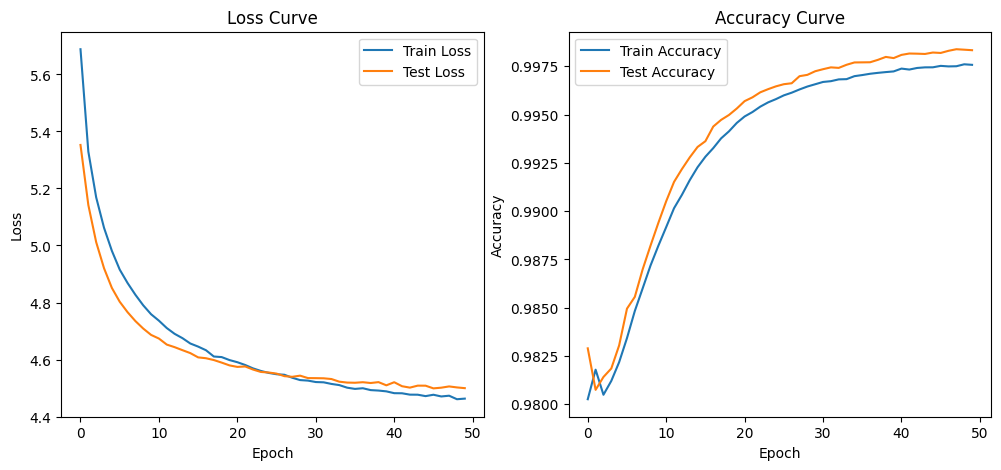

In [44]:
# Plot learning curves
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()